In [1]:
import json

In [10]:
annotations_file = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_mscoco_val2014_annotations.json"
questions_file = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_OpenEnded_mscoco_val2014_questions.json"

In [11]:
with open(annotations_file, 'rb') as f:
    annotations = json.load(f)

with open(questions_file, 'rb') as f:
    questions = json.load(f)

In [4]:
annotations.keys()

dict_keys(['info', 'license', 'data_subtype', 'annotations', 'data_type'])

In [12]:
questions.keys()

dict_keys(['info', 'task_type', 'data_type', 'license', 'data_subtype', 'questions'])

In [5]:
annotations

{'info': {'description': 'This is v2.0 of the VQA dataset.',
  'url': 'http://visualqa.org',
  'version': '2.0',
  'year': 2017,
  'contributor': 'VQA Team',
  'date_created': '2017-04-26 17:00:44'},
 'license': {'url': 'http://creativecommons.org/licenses/by/4.0/',
  'name': 'Creative Commons Attribution 4.0 International License'},
 'data_subtype': 'val2014',
 'annotations': [{'question_type': 'none of the above',
   'multiple_choice_answer': 'down',
   'answers': [{'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 1},
    {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 2},
    {'answer': 'at table', 'answer_confidence': 'yes', 'answer_id': 3},
    {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 4},
    {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 5},
    {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 6},
    {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 7},
    {'answer': 'down', 'answer_confidence': '

In [6]:
len(annotations['annotations'])

214354

In [8]:
annotations['annotations'][0]

{'question_type': 'none of the above',
 'multiple_choice_answer': 'down',
 'answers': [{'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 1},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 2},
  {'answer': 'at table', 'answer_confidence': 'yes', 'answer_id': 3},
  {'answer': 'skateboard', 'answer_confidence': 'yes', 'answer_id': 4},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 5},
  {'answer': 'table', 'answer_confidence': 'yes', 'answer_id': 6},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 7},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 8},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 9},
  {'answer': 'down', 'answer_confidence': 'yes', 'answer_id': 10}],
 'image_id': 262148,
 'answer_type': 'other',
 'question_id': 262148000}

In [15]:
questions['questions'][0]

{'image_id': 262148,
 'question': 'Where is he looking?',
 'question_id': 262148000}

In [ ]:
train_image_dir_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/train2017"
# http://images.cocodataset.org/zips/val2014.zip
# /scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/val2014/COCO_val2014_000000262148.jpg

In [2]:
import json
import os

from PIL import Image
from torch.utils.data import Dataset

In [3]:
class VQADataset(Dataset):
    def __init__(
        self, image_dir_path, question_path, annotations_path, is_train, dataset_name
    ):
        self.questions = json.load(open(question_path, "r"))["questions"]
        if annotations_path is not None:
            self.answers = json.load(open(annotations_path, "r"))["annotations"]
        else:
            self.answers = None
        self.image_dir_path = image_dir_path
        self.is_train = is_train
        self.dataset_name = dataset_name
        if self.dataset_name in {"vqav2", "ok_vqa"}:
            self.img_coco_split = self.image_dir_path.strip("/").split("/")[-1]
            assert self.img_coco_split in {"train2014", "val2014", "test2015"}

    def __len__(self):
        return len(self.questions)

    def get_img_path(self, question):
        if self.dataset_name in {"vqav2", "ok_vqa"}:
            return os.path.join(
                self.image_dir_path,
                f"COCO_{self.img_coco_split}_{question['image_id']:012d}.jpg"
                if self.is_train
                else f"COCO_{self.img_coco_split}_{question['image_id']:012d}.jpg",
            )
        elif self.dataset_name == "vizwiz":
            return os.path.join(self.image_dir_path, question["image_id"])
        elif self.dataset_name == "textvqa":
            return os.path.join(self.image_dir_path, f"{question['image_id']}.jpg")
        else:
            raise Exception(f"Unknown VQA dataset {self.dataset_name}")

    def __getitem__(self, idx):
        question = self.questions[idx]
        img_path = self.get_img_path(question)
        image = Image.open(img_path)
        image.load()
        results = {
            "image": image,
            "question": question["question"],
            "question_id": question["question_id"],
        }
        if self.answers is not None:
            answers = self.answers[idx]
            results["answers"] = [a["answer"] for a in answers["answers"]]
        return results

In [4]:
image_dir_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/val2014"
questions_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_OpenEnded_mscoco_val2014_questions.json"
annotations_path = "/scratch/workspace/asureddy_umass_edu-llm_alignment/dataset/vqa/v2_mscoco_val2014_annotations.json"
vqa_dataset = VQADataset(image_dir_path, questions_path, annotations_path,True, "vqav2")

In [9]:
vqa_dataset[111]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=378x640>,
 'question': 'What color is the sky?',
 'question_id': 393277004,
 'answers': ['blue',
  'blue',
  'blue',
  'blue, gray',
  'blue',
  'blue',
  'blue',
  'blue',
  'blue',
  'blue']}

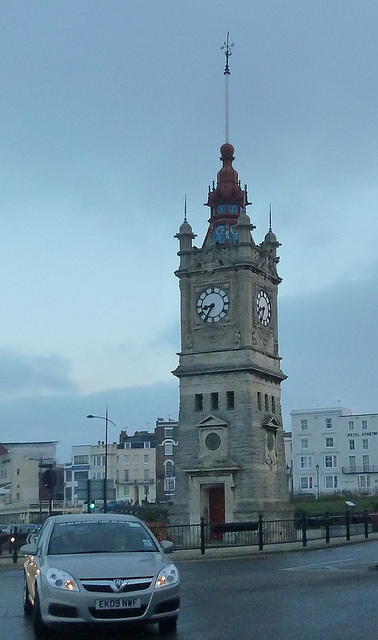

In [8]:
vqa_dataset[111]['image']